# Лабораторная работа по A*

В данной работе вам предстоит реализовать алгоритм A* для поиска пути для робота, передвигающегося на клетчатом поле. Каждая клетка может быть свободной или заблокированной препятствием, робот может ходить только по свободным клеткам. Поле предполагается $4$-ёх связным, что означает, что из каждой клетки робот может сходить в $4$ соседних: сверху, снизу, справа, слева (при условии, что они свободны). Стоимости переходов во всех соседей одинаковы (можно считать, равны $1$).

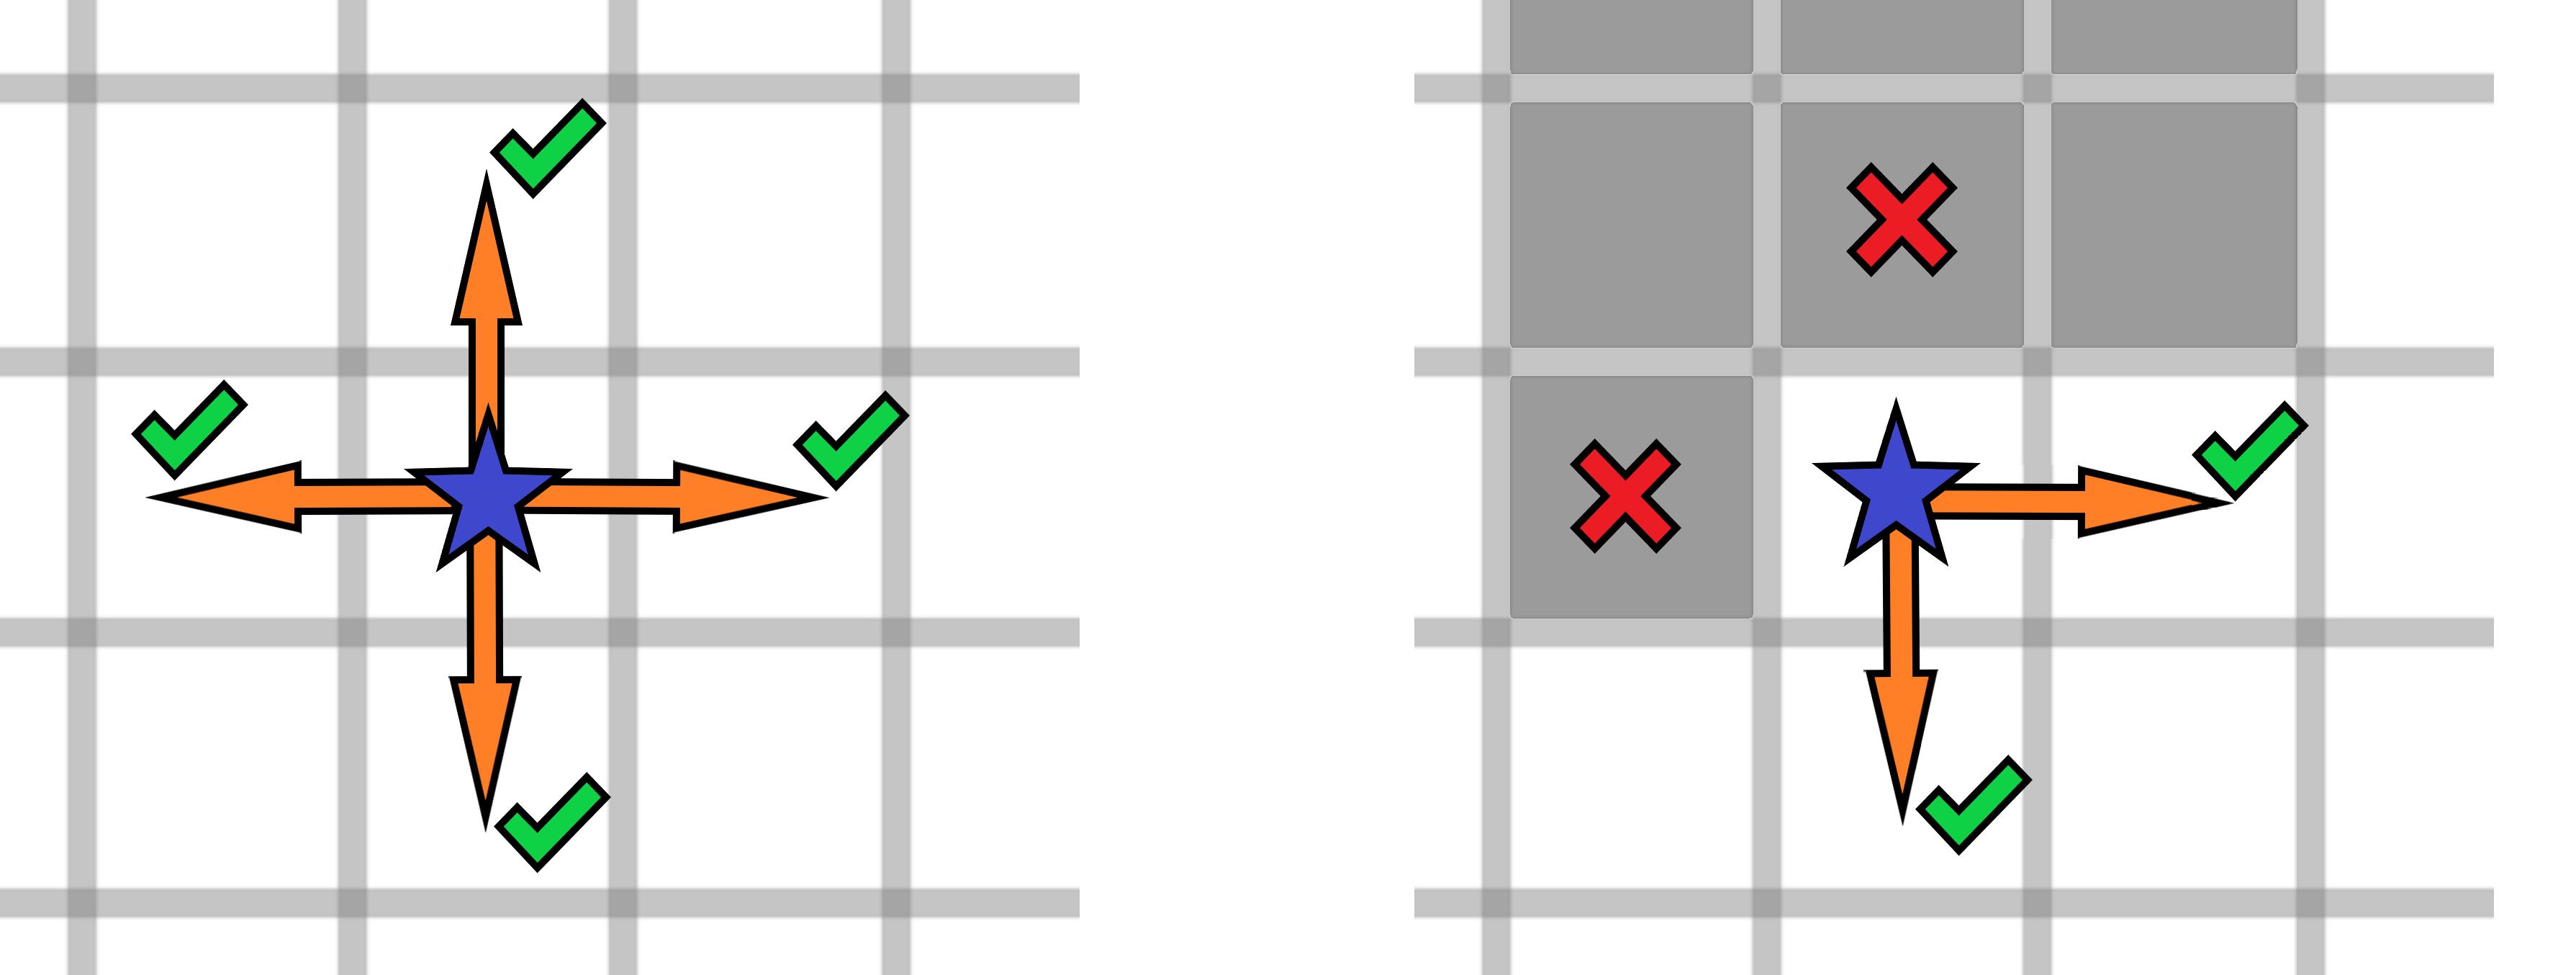

Основной код уже написан, вам же остаётся только реализовать вспомогательные функции (получение соседей, проверка коллизии и тд), а также сам алгоритм A*. Для этого достаточно заполнить пропуски, отмеченные надписью `# CODE HERE`.

Если у вас всё получится, то в конце сможете поиграться с красивой визуализацией! Даже двумя...

#### Напоминание алгоритма A*

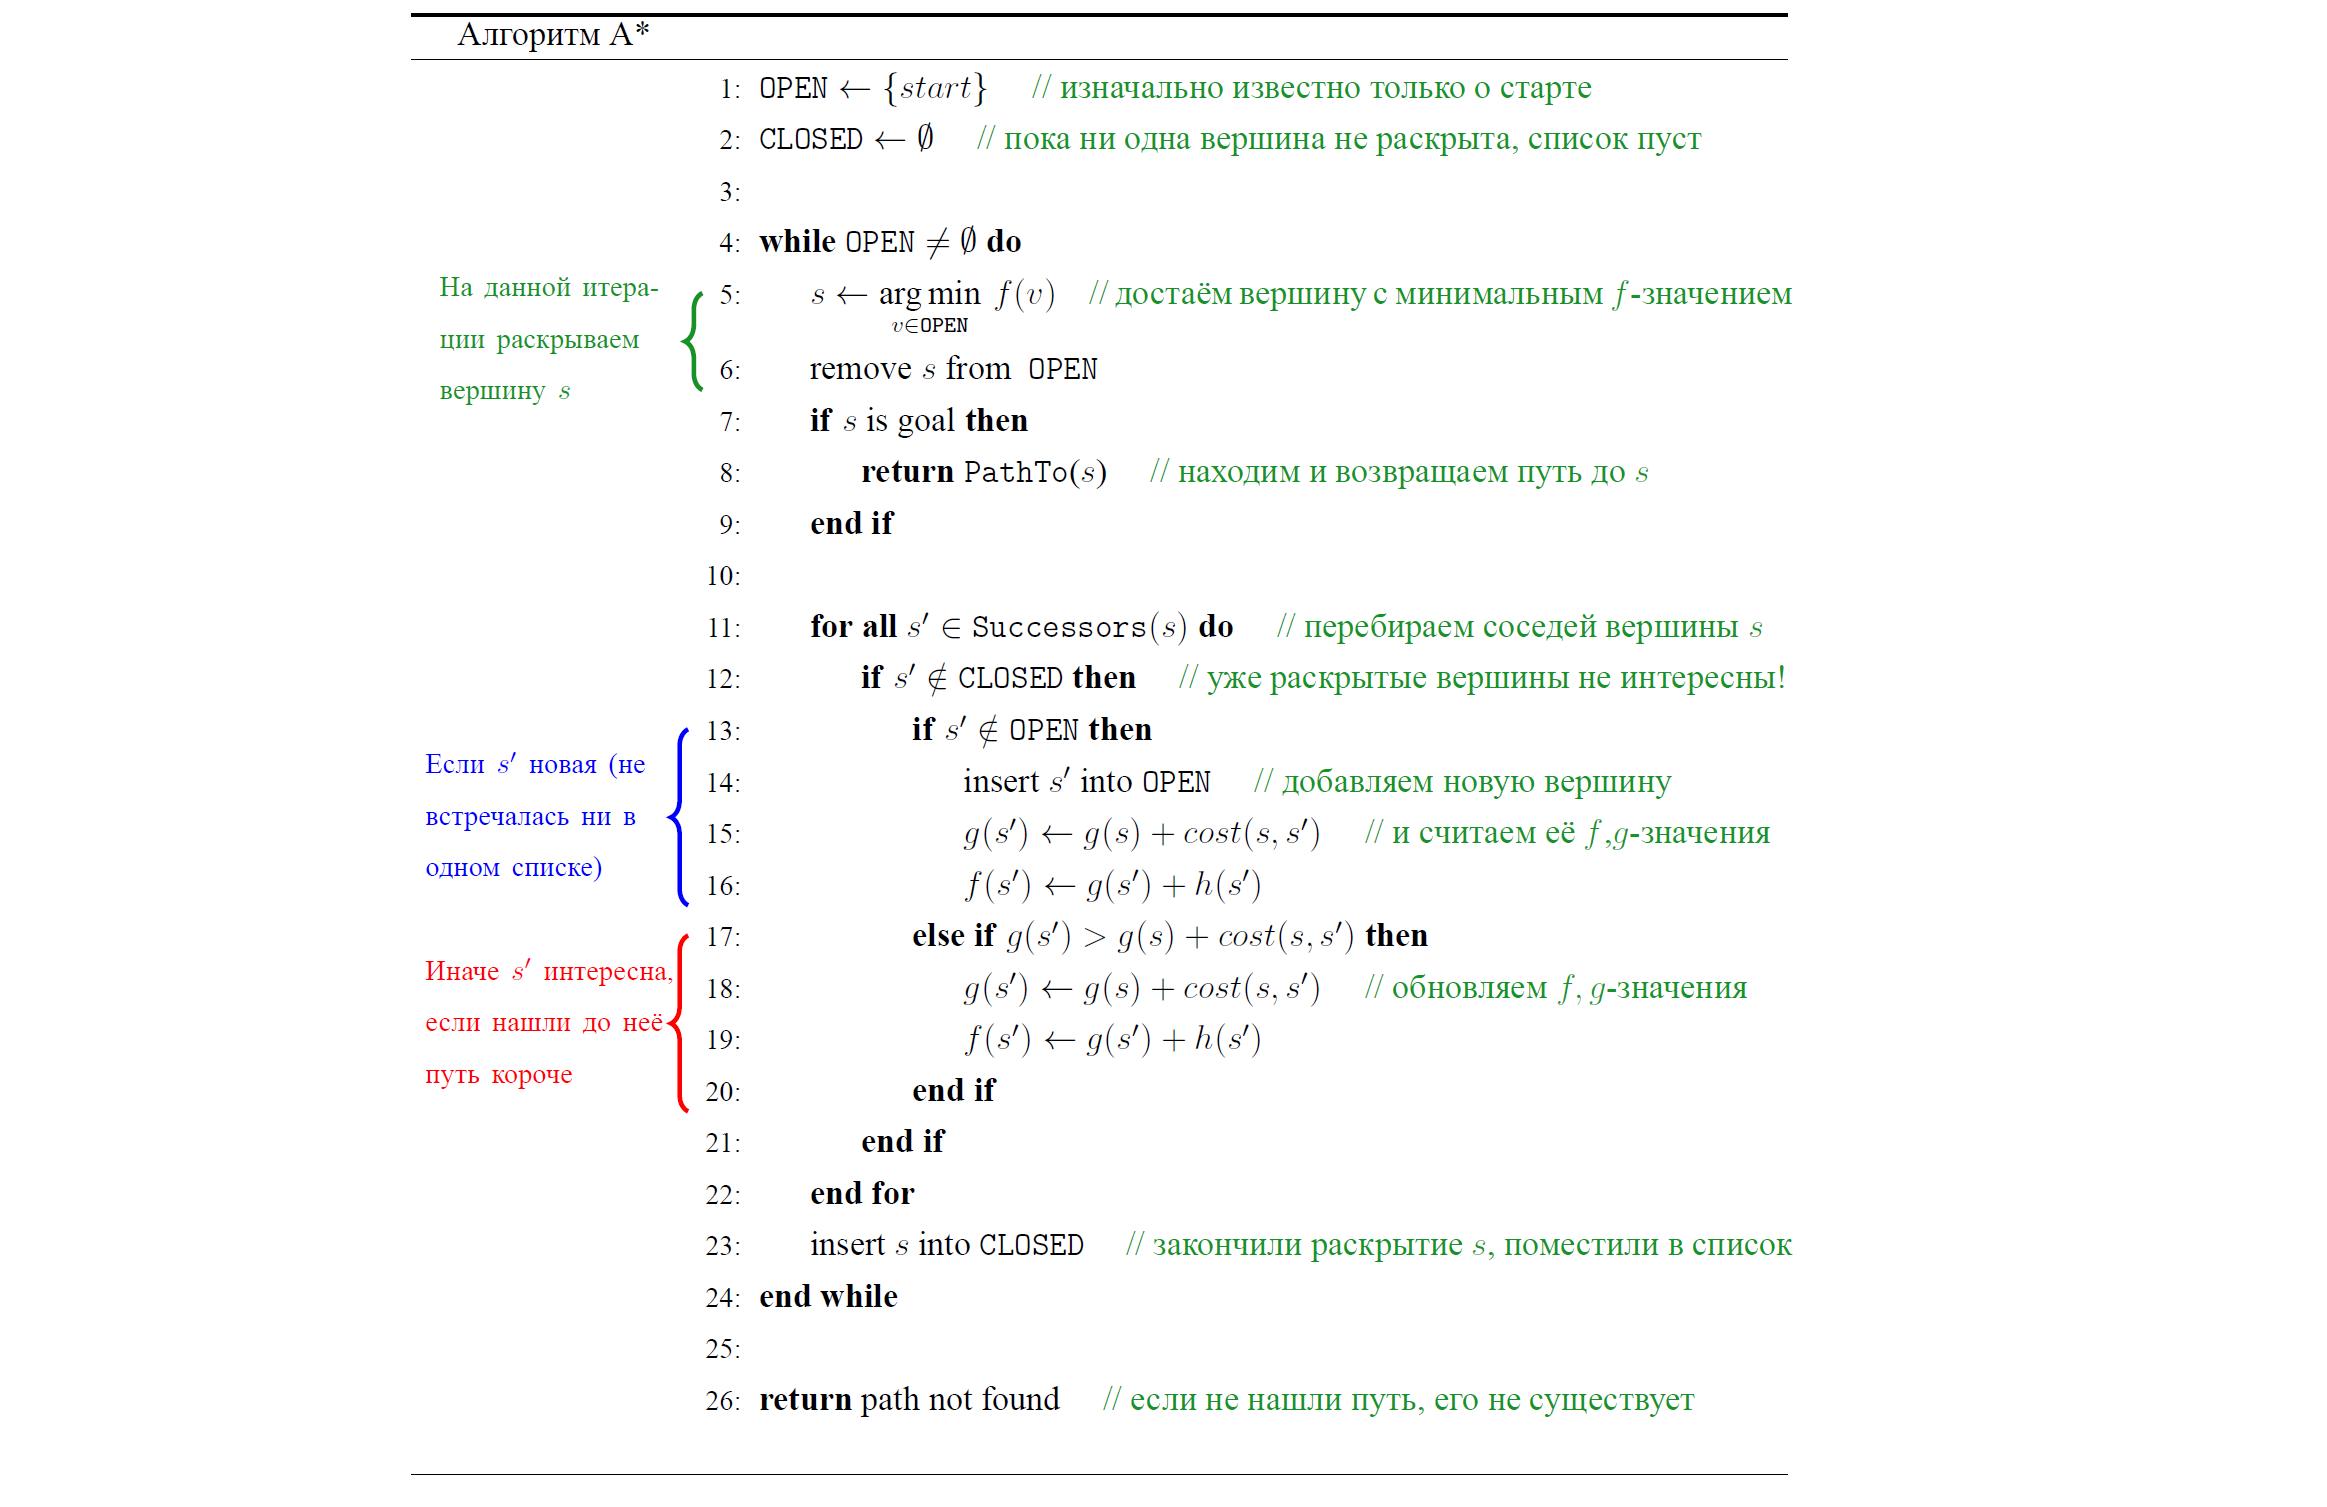

$\textbf{Замечание:}$ Поскольку в рамках этой работы мы считаем эвристику $h$ хорошей (монотонной!), то для вершин в $\texttt{CLOSED}$ гарантированно уже известен путь кратчайшей длины от старта. Именно поэтому в строке `12` псевдокода нас такие вершины больше не интересуют. Однако в общем случае, если эвристика произвольная, вершины из $\texttt{CLOSED}$ могут быть перераскрыты.  

#### Немного дополнительной информации:

Алгоритм A* является модификацией широко используемого алгоритма Дейкстры. Несмотря на свою простоту и элегантность, оба появились сравнительно недавно (позже, чем полёт в космос!). Эдсгер Дейкстра представил свой алгоритм в 1959 году, и только в 1968 году Питером Хартом, Нильсом Нильсоном и Бертрамом Рафаэлем была предложена его модификация &ndash; A*. Сейчас же эти алгоритмы используются в марсоходах, навигаторах, компьютерных сетях и много-много где ещё. Это к тому, что на наш век открытий ещё хватит:)

Оригинальная статья про A*:
[Hart, P., Nilsson, N., & Raphael, B. (1968). A Formal Basis for the Heuristic Determination of Minimum Cost Paths.](https://ai.stanford.edu/~nilsson/OnlinePubs-Nils/PublishedPapers/astar.pdf)

&nbsp;

&nbsp;

&nbsp;

### Загрузка и импорт нужных библиотек

Для выполнения данной работы (а точнее, её визуализации), вам потребуется библотека `pygame`. Запуск следующей ячейки проверит её наличие и установит, если её нет. Кстати, эта же бибилиотека используется для создания игр на Python.

In [1]:
!pip install pygame


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Далее импортируем все неоходимые библиотеки. Убедитесь, что файл `vizualizator.py` у вас лежит в той же директории, что и данная тетрадка &ndash; он тоже играет роль библиотеки.

In [2]:
import math
import pygame
from vizualizator import GridMap, Simulator

pygame 2.6.1 (SDL 2.28.4, Python 3.10.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Инициализация

Следующую ячейку вам менять не обязательно: в ней просто фиксируются размеры клетчатого поля, на котором будет ходить робот, а также инициализируются $4$ двумерных массива (поле, $f,g$-значения и родители для каждой клетки) и списки $\texttt{OPEN}$ и $\texttt{CLOSED}$.

Напоминание Python:
1) В данной работе основным объектом является клетчатое поле, клетки которого имеют две целочисленные координаты (номер строки и столбца). Их удобно записать парой вида $(i,j)$. Pyhton коорректно работает с такими данными. Более того, можно сохранить пару в отдельную переменную и обращаться к каждой компненте отдельно: `x = (i,j)`, `x[0]` - это первая координата ($i$), $x[1]$ - вторая ($j$).
 
2) Двумерный список следует воспринимать как таблицу, где в каждой строке написано некоторое значение. Для получения значения по $(i,j)$ (традиционно, первая координата, $i$ &ndash; номер строки, а вторая координата, $j$ &ndash; номер столбца) из двумерного списка `a`, достаточно написать в коде `a[i][j]`. Для того, чтобы установить значение равным $x$, просто пишем `a[i][j] = x`.

3) В Python есть специальное значение `None`, которое обозначает, что данных нет. Чтобы проверить, что какая-то переменная `x` является None, достаточно написать обычное if-условие `if(x is None):`.

4) В Python есть списки, которые являются просто упорядоченным набором элементов. Создать пустой список можно, например, так: `a = []`. Добавить в список элемент `x` можно через `a.append(x)`. Удалить из списка последний элемент и сохранить его значение в переменной `x` можно через `x = a.pop()`. Если вы хотите перебрать все элементы в списке, то удобнее всего сделать это через `for x in a:`.

5) В Python есть множества. Это такие наборы данных, для которых очень быстро проверяется наличие в них элемента. Создаются, например так: `a = set()`. Добавить элемент в них можно через `a.add(x)`. Проверка на наличие элемента `x` осуществляется так: `if (x in a):`.

In [3]:
# Размеры клетчатого поля: 
cols = 50  # число столбцов -> координата j = 0 ... cols-1
rows = 30  # число строк -> i = 0 ... rows-1

# Инициализация: двумерные списки
grid_map = [[0 for j in range(cols)] for i in range(rows)]  # клетчатое поле: по (i,j) хранит 0, если клетка с такими 
                                                            # координатами свободна и 1 иначе (изначально заполнена 0 - все свободны)
f_values = [[float('inf') for j in range(cols)] for i in range(rows)]  # f-значения: по (i,j) хранит f-значение у клетки с координатами i,j
                                                                       # (изначально заполнена бескончено большим значением)
g_values = [[float('inf') for j in range(cols)] for i in range(rows)]  # g-значения: аналогично
parent = [[None for j in range(cols)] for i in range(rows)]  # родители: по (i,j) хранит координаты (тоже как пару (a,b)) клетки, являющейся
                                                             # родителем клетки с координатами i,j (родитель - это та клетка, раскрытие
                                                             # которой привело к созданию/обновлению данной)
                                                             # (изначально заполнена None - пока родителей не знаем)

# Инциализация: списки
OPEN = []  # OPEN: обычный питоновский список, куда будут складываться пары (i,j) - координаты клеток
CLOSED = set()  # CLOSED: питоновский set, куда будем класть пары (i,j) - координаты раскрытых клеток

# Просто функция, вызов которой сбрасывает все переменные выше до начальных значений (вам вызывать не потребуется!):
def reset():
    for i in range(rows):
        for j in range(cols):
            f_values[i][j] = float('inf')
            g_values[i][j] = float('inf')
            parent[i][j] = None
    OPEN.clear()
    CLOSED.clear()

### Функции работы с клетчатым полем:

Далее вам нужно реализовать три функции: `check_cell` (проверка коллизии с препятствием), `get_successors` (получение соседей клетки),
`cost` (получение стоимости перехода из клетки в соседа).

In [4]:
# Функция проверки клетки координатам (i, j) на коллизию: возвращает True (если клетка свободна) или False (иначе):
def check_cell(i, j):
    # CODE HERE

# Функция получает список соседей (из числа свободных клеток!) клетки с координатами (i, j):
# (например, у (0,0) при отсутствии препятствий список будет [(1,0), (-1,0), (0,1), (0,-1)])
def get_successors(i, j):
    # CODE HERE

# Функция получает стоимость перехода из клетки (i1,j1) в (i2, j2):
# (да, это всегда 1, но можете сделать иначе и посмотреть, что будет)
def cost(i1, j1, i2, j2):
    # CODE HERE

### Функции поиска

Здесь реализуется основа A*, а именно работа со списками $\texttt{OPEN}, \texttt{CLOSED}$.

In [6]:
# Функция проверяет, что клетка (i,j) уже раскрыта - возвращает True (если раскрыта) и False (иначе):
def was_expanded(i, j):
    # CODE HERE

# Функция получает (и удаляет из списка) клетку из OPEN, у которой минимальное f-значение - возвращает пару (i,j):
def get_best_from_open():
    # CODE HERE

# Функция добавляет клетку (i,j) в список OPEN:
def add_to_open(i, j):
    # CODE HERE

# Аналогично - в список CLOSED:
def add_to_closed(i, j):
    # CODE HERE

# Функция проверяет, что клетка (i,j) уже находится в OPEN:
def in_open(i, j):
    # CODE HERE

### Алгоритм A*

Далее финал! Пишем A*.

In [7]:
# Эта функция восстанавливает кратчайший путь до клетки (last_i, last_j):
# (напомним, этот путь становится известен только, когда клетка попала в список CLOSED - до этого момента эта фукция не сработает)
# (ваша задача только в нужном месте её вызывать, менять ничего не нужно)
def get_path(last_i, last_j):
    path = []
    current = (last_i, last_j)
    while current is not None:
        i, j = current
        path.append((i, j))
        current = parent[i][j]
    path.reverse()
    return path

In [9]:
# Эвристическая функция - некоторая оценка длины кратчайшего пути от клетки (i,j) до целевой клетки (finish_i, finish_j):
# (если тут вставить просто return 0, то A* будет эквивалентен алгоритму Дейкстры)
def heuristic(i, j, finish_i, finish_j):
    # CODE HERE

# Сам алгоритм A*: он должен найти путь от (start_i, start_j) до (finish_i, finish_j):
def search_astar(start_i, start_j, finish_i, finish_j): 
    g_values[start_i][start_j] = 0
    f_values[start_i][start_j] = heuristic(start_i, start_j, finish_i, finish_j)
    add_to_open(start_i, start_j)

    while True:           
        if len(OPEN) == 0:
            return []

        # CODE HERE

        # Это обязательно оставить - просто для визуализации:
        yield None

### Визуализация

Если вы добрались до данной точки, возможно вы наивно полагаете, что успешно справились с задачей? Что ж, проверим:)

Далее идёт три ячейки. Вторая и третья отвечают за запуск двух визуализаций, которые будут иллюстрировать написанный вами A*. При запуске обеих визуализаций должно открыться отдельное окно в операционной системе, где будет нарисовано клетчатое поле. Вы сможете взаимодействовать с ним:
1) Клик `левой кнопкой` мыши по клетке: поставить старт, финиш, препятствие
2) Клик `правой кнопкой` мыши: очистить клетку
3) Кнопка `C` очищает карту полностью
4) Кнопка `пробел` запускает поиск пути от старта к финишу

Первая визуализация демонстрирует обычный поиск на заранее известной карте. Вам будут отображаться клетки, которые в данный момент находятся в списках OPEN и CLOSED.

Вторая визуализация моделирует ту же задачу, но с частичной наблюдаемостью: робот видит карту только в некотором радиусе (парамтер `R`), остальную часть карты он считает свободной от препятствий. В таких предположениях он ищет путь. Затем он делает один шаг вдоль него, получает информацию о новых препятствиях и пересчитывает путь. 

In [10]:
WIDTH = 1000  # размеры окна для рисования
HEIGHT = 800
searching_map = GridMap(rows, cols, HEIGHT, WIDTH)  # инициализируем поле из клеток rows на cols
s = Simulator(searching_map, grid_map, search_astar, reset, OPEN, CLOSED)  # создаём симулятор

In [11]:
window = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("A* Path Finding Algorithm")
s.run(window)

Старт/финиш не могут быть препятствием!
Нашли путь!
Клетка уже является стартом/финишем, менять нельзя!
Нашли путь!
Нашли путь!
Клетка уже является стартом/финишем, менять нельзя!
Клетка уже является стартом/финишем, менять нельзя!
Нашли путь!


In [12]:
window = pygame.display.set_mode((WIDTH, HEIGHT))
pygame.display.set_caption("A* Path Finding Algorithm with Partial Observation")
s.run(window, save_frames=False, partial_observed=True, R=4)

Клетка уже является стартом/финишем, менять нельзя!
Клетка уже является стартом/финишем, менять нельзя!
Клетка уже является стартом/финишем, менять нельзя!
Клетка уже является стартом/финишем, менять нельзя!
Мы на месте!
Мы на месте!
